<a href="https://colab.research.google.com/github/ss1u21/Msc-Data-and-Decision-Analytics/blob/main/Pmedian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install spopt
%pip install matplotlib_scalebar
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 2.4 MB 25.3 MB/s 
     |████████████████████████████████| 14.2 MB 38.0 MB/s 
     |████████████████████████████████| 1.0 MB 42.4 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 6.3 MB 29.3 MB/s 
     |████████████████████████████████| 16.7 MB 445 kB/s 
     |████████████████████████████████| 1.0 MB 49.2 MB/s 
     |████████████████████████████████| 116 kB 43.2 MB/s 
  Created wheel for esda: filename=esda-2.4.3-py3-none-any.whl size=122781 sha256=16d6fcebf381cb5e56a71aeccc71c9f426d2cced2f2fe2bd17ea24d6031dd638
  Stored in directory: /root/.cache/pip/wheels/37/07/2e/2aa4874ca25fa442a3912c74e53780da19d25ec1d58bac5d30
Successfully built esda
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Selec

In [2]:
from spopt.locate import PMedian
from spopt.locate.util import simulated_geo_points
import pandas as pd
import numpy
import geopy.distance
import geopandas
import pulp
import spaghetti
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [3]:
from google.colab import files
uploaded = files.upload()

Saving parcels.csv to parcels.csv
Saving Portsmouth_6MC.csv to Portsmouth_6MC.csv


In [4]:
demand_points = pd.read_csv("parcels.csv", sep=',')
demand_points=demand_points.groupby(['Latitude','Longitude']).size().reset_index(name='demand') 
colnames=['Latitude', 'Longitude','NAME' ]
facility_points=pd.read_csv("Portsmouth_6MC.csv",names=colnames, sep=',')

In [5]:
facility_points_name=facility_points['NAME']
facility_points_latitude=facility_points['Latitude']
facility_points_longitude=facility_points['Longitude']
facility_points_latitude

0    50.847806
1    50.794942
2    50.846475
3    50.817339
4    50.796638
5    50.843917
Name: Latitude, dtype: float64

In [6]:
def distance(x,y):
    #print(x)
    #print(y)
    coords_1 = x
    coords_2 = y
    return geopy.distance.geodesic(coords_1, coords_2).km

In [7]:
Latitude=demand_points["Latitude"].tolist()
Longitude=demand_points["Longitude"].tolist()
Facilities=[[50.847806,-1.088163],[50.794942,-1.059197],[50.846475,-1.04657],[50.817339,-1.080083],[50.796638,-1.091671],[50.843917,-1.06817]]

In [8]:
distance_array = np.zeros( (6, len(Latitude)) )
distance_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
for i in range(0,6):
    for j in range(0,len(Latitude)):
        distance_array[i][j]=distance((Latitude[j],Longitude[j]),(Facilities[i][0],Facilities[i][1]))

In [10]:
facility_points

,Latitude,Longitude,NAME
0,50.847806,-1.088163,Hillside and Wymering CC
1,50.794942,-1.059197,Beddow Library
2,50.846475,-1.046570,Drayton CC
3,50.817339,-1.080083,North End Library
4,50.796638,-1.091671,Central Library
5,50.843917,-1.068170,Cosham CC


In [11]:
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,
    geometry=geopandas.points_from_xy(
        facility_points.Longitude, facility_points.Latitude
    ),
)
demand_points_gdf = geopandas.GeoDataFrame(
    demand_points,
    geometry=geopandas.points_from_xy(demand_points.Longitude, demand_points.Latitude),
)

In [12]:
facility_points_gdf

,Latitude,Longitude,NAME,geometry
0,50.847806,-1.088163,Hillside and Wymering CC,POINT (-1.08816 50.84781)
1,50.794942,-1.059197,Beddow Library,POINT (-1.05920 50.79494)
2,50.846475,-1.046570,Drayton CC,POINT (-1.04657 50.84647)
3,50.817339,-1.080083,North End Library,POINT (-1.08008 50.81734)
4,50.796638,-1.091671,Central Library,POINT (-1.09167 50.79664)
5,50.843917,-1.068170,Cosham CC,POINT (-1.06817 50.84392)


In [13]:
demand_points_gdf

,Latitude,Longitude,demand,geometry
0,50.779225,-1.078916,2,POINT (-1.07892 50.77922)
1,50.779321,-1.079666,1,POINT (-1.07967 50.77932)
2,50.779550,-1.076754,2,POINT (-1.07675 50.77955)
3,50.779600,-1.077406,4,POINT (-1.07741 50.77960)
4,50.779639,-1.078681,1,POINT (-1.07868 50.77964)
...,...,...,...,...
2385,50.855064,-1.108011,1,POINT (-1.10801 50.85506)
2386,50.855168,-1.109955,1,POINT (-1.10996 50.85517)
2387,50.855192,-1.110693,2,POINT (-1.11069 50.85519)
2388,50.855198,-1.113804,1,POINT (-1.11380 50.85520)


In [14]:
service_dist = distance_array.max()+0.5 # 0.5 added of there is any rounding done by the package
#ai = demand_points_gdf['demand'].to_list()
ai=[1]*2390
TdisMat=np.transpose(distance_array)
TdisMat.shape

(2390, 6)

In [15]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

dv_colors = [
    "saddlebrown",
    "darkgoldenrod",
    "mediumseagreen",
    "lightskyblue",
    "lavender",
    "darkslategray",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "cyan",
    "limegreen",
    "peachpuff",
    "blueviolet",
    "fuchsia",
    "thistle",
]

def plot_results(model, facility_points_gdf, demand_points_gdf, facility_count, title, p):

    arr_points = []
    fac_sites = []

    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = demand_points_gdf.iloc[model.fac2cli[i]]["geometry"]
            arr_points.append(geom)
            fac_sites.append(i)
    # print(fac_sites)
    # print(arr_points)
    #model.uncovered_clients()
    #xcov = model.n_cli_uncov

    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    # study_area.plot(ax=ax, alpha=.5, fc="tan", ec="k", zorder=1)
    # _patch = Patch(alpha=.5, fc="tan", ec="k", label="Dissolved Service Areas")
    # legend_elements.append(_patch)

    demand_points_gdf.plot(
        ax=ax, fc="k", ec="k", marker="s", markersize=2, zorder=2
    )
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            marker="s",
            markerfacecolor="k",
            markeredgecolor="k",
            ms=3,
            linewidth=0,
            #label=f"Demand sites not covered ($n$={"xcov"})"
        )
    )

    facility_points_gdf.plot(
        ax=ax, fc="brown", marker="*", markersize=80, zorder=8
    )
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            marker="*",
            markerfacecolor="brown",
            markeredgecolor="brown",
            ms=7,
            lw=0,
            label=f"Store sites ($n$={facility_count})"
        )
    )

    _zo, _ms = 4, 4
    for i in range(len(arr_points)):

        cset = dv_colors[i]
        fac = fac_sites[i]
        fname = facility_points_gdf.iloc[[fac]]["NAME"]
        print(fname)
        fname = f"{fname.squeeze().replace('_', ' ')}"

        gdf = geopandas.GeoDataFrame(arr_points[i])

        label = f"Demand sites covered by {fname}"
        gdf.plot(ax=ax, zorder=_zo, ec="k", fc=cset, markersize=40*_ms)
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="o",
                markerfacecolor=cset,
                markeredgecolor="k",
                ms= _ms + 7,
                lw=0,
                label=label
            )
        )

        facility_points_gdf.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec="k", lw=2
        )
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="*",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=2,
                ms=20,
                lw=0,
                label=fname,
            )
        )

        _zo += 1
        _ms -= (1)*(4/p)
        print(fac)
        print(gdf.size)

    plt.title(title, fontsize=20)
    kws = dict(loc="upper left", bbox_to_anchor=(1.05, .7), fontsize=15)
    plt.legend(handles=legend_elements, **kws)

    x, y, xyc, arrow_length, c = 0.925, 0.15, "axes fraction", 0.1 , "center"
    xy, xyt = (x, y), (x, y-arrow_length)
    ap = dict(facecolor="black", width=5, headwidth=10)
    kws = dict(arrowprops=ap, ha=c, va=c, fontsize=20)
    plt.annotate("N", xy=xy, xycoords=xyc, xytext=xyt, **kws)

    plt.gca().add_artist(ScaleBar(1))

In [16]:
for _df in [facility_points_gdf, demand_points_gdf]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

0    Hillside and Wymering CC
Name: NAME, dtype: object
0
215
1    Beddow Library
Name: NAME, dtype: object
1
613
2    Drayton CC
Name: NAME, dtype: object
2
201
3    North End Library
Name: NAME, dtype: object
3
575
4    Central Library
Name: NAME, dtype: object
4
589
5    Cosham CC
Name: NAME, dtype: object
5
197


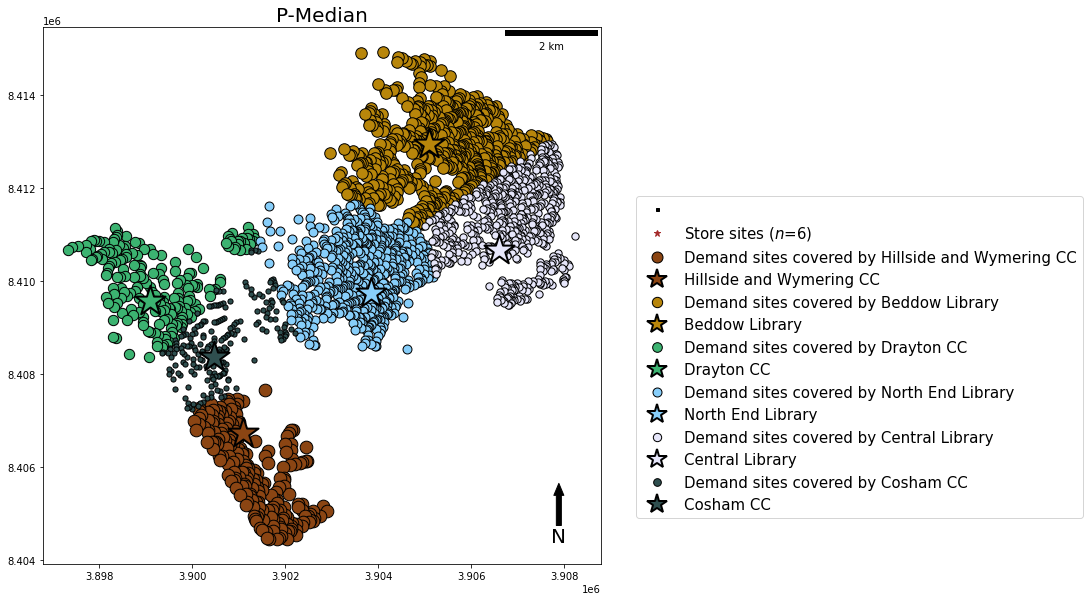

In [17]:
from spopt.locate import PMedian
pmedian = PMedian.from_cost_matrix(
    TdisMat, ai, p_facilities=6
)

pmedian = pmedian.solve(pulp.GLPK(msg=False))
pmedian.facility_client_array()
plot_results(pmedian, facility_points_gdf, demand_points_gdf, facility_points_gdf.shape[0], "P-Median", 6)

In [18]:
df_final=pd.DataFrame()
for i in range(len(pmedian.fac2cli)):
  
  facility_name=[facility_points_name[i]]*len(pmedian.fac2cli[i])
  facility_latitude=[facility_points_latitude[i]]*len(pmedian.fac2cli[i])
  facility_longitude=[facility_points_longitude[i]]*len(pmedian.fac2cli[i])
  f2cdf=pd.DataFrame()
  f2cdf['client']=pmedian.fac2cli[i]
  f2cdf['facility_name']=facility_name
  f2cdf['facility_Latitude']=facility_latitude
  f2cdf['facility_Longitude']=facility_longitude
  df_final=transaction=pd.concat([df_final,f2cdf], axis=0)

print(df_final)
  #print(len(i))

     client             facility_name  facility_Latitude  facility_Longitude
0      1902  Hillside and Wymering CC          50.847806           -1.088163
1      1907  Hillside and Wymering CC          50.847806           -1.088163
2      1908  Hillside and Wymering CC          50.847806           -1.088163
3      1914  Hillside and Wymering CC          50.847806           -1.088163
4      1927  Hillside and Wymering CC          50.847806           -1.088163
..      ...                       ...                ...                 ...
192    2307                 Cosham CC          50.843917           -1.068170
193    2312                 Cosham CC          50.843917           -1.068170
194    2319                 Cosham CC          50.843917           -1.068170
195    2320                 Cosham CC          50.843917           -1.068170
196    2333                 Cosham CC          50.843917           -1.068170

[2390 rows x 4 columns]


In [19]:
df_final=df_final.set_index("client")

In [20]:
df_finals=demand_points.join(df_final)

In [21]:
#df_finals=df_finals.drop("geometry",axis=1)
df_finals['distance']=df_finals.apply(lambda row: distance((row['Latitude'],row['Longitude']),(row['facility_Latitude'],row['facility_Longitude']))+0.02,axis=1)


In [22]:
df_finals['distance'].sum()

2323.0096042680093

In [23]:
df_finals

,Latitude,Longitude,demand,geometry,facility_name,facility_Latitude,facility_Longitude,distance
0,50.779225,-1.078916,2,POINT (3907743.025 8412941.171),Central Library,50.796638,-1.091671,2.155730
1,50.779321,-1.079666,1,POINT (3907771.885 8412883.932),Central Library,50.796638,-1.091671,2.124219
2,50.779550,-1.076754,2,POINT (3907597.316 8413057.023),Beddow Library,50.794942,-1.059197,2.132992
3,50.779600,-1.077406,4,POINT (3907625.882 8413009.998),Beddow Library,50.794942,-1.059197,2.155809
4,50.779639,-1.078681,1,POINT (3907687.849 8412922.838),Central Library,50.796638,-1.091671,2.121218
...,...,...,...,...,...,...,...,...
2385,50.855064,-1.108011,1,POINT (3901367.129 8404838.367),Hillside and Wymering CC,50.847806,-1.088163,1.634178
2386,50.855168,-1.109955,1,POINT (3901456.622 8404702.016),Hillside and Wymering CC,50.847806,-1.088163,1.759488
2387,50.855192,-1.110693,2,POINT (3901492.204 8404651.513),Hillside and Wymering CC,50.847806,-1.088163,1.806732
2388,50.855198,-1.113804,1,POINT (3901652.082 8404446.374),Hillside and Wymering CC,50.847806,-1.088163,2.004110


In [ ]:
count_df=df_finals.groupby(['facility_name']).size().reset_index(name='Total_Demand_point')

Text(0.5, 1.0, 'Count of Demand Points per Facility')

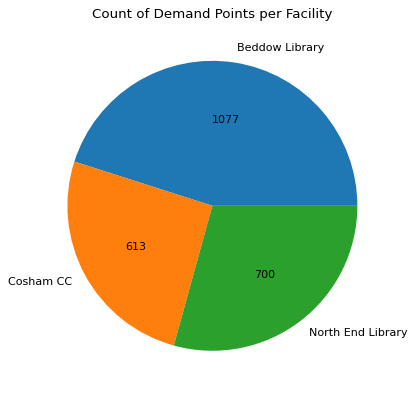

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.pie(count_df['Total_Demand_point'], labels = count_df['facility_name'],autopct=lambda x: '{:.0f}'.format(x*count_df['Total_Demand_point'].sum()/100))
plt.title("Count of Demand Points per Facility")
